In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = '../data/casaData/'

In [3]:
df_text = pd.read_csv('trainListings_textVect_250.csv', index_col=0)
df_numListings = pd.read_csv('trainListings_num.csv', index_col=0)
df_matchedListings = pd.read_csv(path + 'trainMatchedListings.csv')

In [4]:
df_test = df_numListings[['id_clean', 'groupName', 'price_log', 'bedrooms_filled_median',
       'bathrooms_filled_median', 'area_totalLiving_filled', 'plotArea_filled']]

In [5]:
df_test.shape

(83042, 7)

In [6]:
df_text.shape

(82842, 251)

In [7]:
df_all = pd.merge(df_test, df_text, how='inner', 
left_on='id_clean',
right_on='id_clean')

In [8]:
df_all.shape

(82622, 257)

In [9]:
df_matchedListings = df_matchedListings.reset_index()
df_matchedListings.columns = ['id1', 'id2','match']
orig_id = set(df_all['id_clean'].tolist())
df_matchedListings_clean = df_matchedListings.loc[(df_matchedListings['id2'].isin(orig_id)) & (df_matchedListings['id1'].isin(orig_id))]

In [10]:
df_matchedListings_clean['id_list'] = list(zip(df_matchedListings_clean['id1'], df_matchedListings_clean['id2']))
df_matchedListings_clean['id_list'] = df_matchedListings_clean['id_list'].apply(sorted)
df_matchedListings_clean['id_list'] = df_matchedListings_clean['id_list'].apply(lambda x: ''.join(str(n) for n in x))
df_matchedListings_clean = df_matchedListings_clean.drop_duplicates(subset='id_list')

/var/folders/fm/m7sbfrtn37dcz2lvxhvj6q0m0000gn/T/ipykernel_13375/3042379024.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matchedListings_clean['id_list'] = list(zip(df_matchedListings_clean['id1'], df_matchedListings_clean['id2']))
/var/folders/fm/m7sbfrtn37dcz2lvxhvj6q0m0000gn/T/ipykernel_13375/3042379024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matchedListings_clean['id_list'] = df_matchedListings_clean['id_list'].apply(sorted)
/var/folders/fm/m7sbfrtn37dcz2lvxhvj6q0m0000gn/T/ipyke

In [11]:
df_all = df_all.reset_index()

In [12]:
df_all.head()

,index,id_clean,groupName,price_log,bedrooms_filled_median,bathrooms_filled_median,area_totalLiving_filled,plotArea_filled,0,1,...,240,241,242,243,244,245,246,247,248,249
0,0,1,house,17.093,10.0,16.0,4000.0,820000.0,0.0,0.106597,...,0.000000,0.0,0.0,0.087721,0.230942,0.0,0.0,0.0,0.230277,0.110115
1,1,2,house,17.093,10.0,12.0,3000.0,1200000.0,0.0,0.000000,...,0.214868,0.0,0.0,0.160695,0.141020,0.0,0.0,0.0,0.000000,0.000000
2,2,3,house,17.093,10.0,12.0,3000.0,2743.0,0.0,0.000000,...,0.201189,0.0,0.0,0.150465,0.132042,0.0,0.0,0.0,0.000000,0.000000
3,3,4,house,17.093,10.0,12.0,3000.0,1200000.0,0.0,0.000000,...,0.201189,0.0,0.0,0.150465,0.132042,0.0,0.0,0.0,0.000000,0.000000
4,4,5,house,17.093,10.0,12.0,517.0,1200000.0,0.0,0.000000,...,0.177715,0.0,0.0,0.132909,0.116636,0.0,0.0,0.0,0.000000,0.000000


Modelling

In [13]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
scaler = StandardScaler()
ohE = OneHotEncoder()
ordE = OrdinalEncoder()

from sklearn.compose import ColumnTransformer

In [15]:
num_cols = ['price_log', 'bedrooms_filled_median', 'bathrooms_filled_median', 'area_totalLiving_filled', 'plotArea_filled']
cat_cols = ['groupName']

In [16]:
transformers = [
    ('num', StandardScaler(), num_cols), # pass list 
    ('cat', OneHotEncoder(), cat_cols)
]

In [17]:
transformer = ColumnTransformer(transformers=transformers, remainder='passthrough')

In [18]:
df_all_transformed = pd.DataFrame(transformer.fit_transform(df_all))

In [19]:
df_all_transformed.columns = transformer.get_feature_names_out()

In [20]:
df_pairedListings = df_matchedListings_clean.merge(df_all_transformed, left_on='id1', right_on='remainder__id_clean', how='left').merge(df_all_transformed, left_on='id2', right_on='remainder__id_clean', how='left')

In [21]:
df_pairedListings = df_pairedListings.drop(columns=['id1', 'id2', 'id_list', 'remainder__id_clean_x', 'remainder__id_clean_y'])

In [22]:
df_pairedListings.head()

,match,num__price_log_x,num__bedrooms_filled_median_x,num__bathrooms_filled_median_x,num__area_totalLiving_filled_x,num__plotArea_filled_x,cat__groupName_apartment_x,cat__groupName_house_x,cat__groupName_investment_x,cat__groupName_other_x,...,remainder__240_y,remainder__241_y,remainder__242_y,remainder__243_y,remainder__244_y,remainder__245_y,remainder__246_y,remainder__247_y,remainder__248_y,remainder__249_y
0,1,3.485161,0.522516,4.018781,1.359193,3.754691,0.0,1.0,0.0,0.0,...,0.214868,0.0,0.0,0.160695,0.141020,0.0,0.000000,0.0,0.0,0.0
1,1,3.485161,0.522516,4.018781,1.359193,3.754691,0.0,1.0,0.0,0.0,...,0.201189,0.0,0.0,0.150465,0.132042,0.0,0.000000,0.0,0.0,0.0
2,1,3.485161,0.522516,4.018781,1.359193,3.754691,0.0,1.0,0.0,0.0,...,0.201189,0.0,0.0,0.150465,0.132042,0.0,0.000000,0.0,0.0,0.0
3,1,3.485161,0.522516,4.018781,1.359193,3.754691,0.0,1.0,0.0,0.0,...,0.177715,0.0,0.0,0.132909,0.116636,0.0,0.000000,0.0,0.0,0.0
4,1,3.485161,0.522516,4.018781,1.359193,3.754691,0.0,1.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.159375,0.0,0.104743,0.0,0.0,0.0


In [78]:
df_pairedListings_sample = df_pairedListings.groupby('match').apply(lambda x: x.sample(frac=0.10)) 

In [23]:
X = df_pairedListings.drop(columns='match')
y = df_pairedListings['match']

In [81]:
X_sample = df_pairedListings_sample.drop(columns='match')
y_sample = df_pairedListings_sample['match']

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=15)

In [83]:
X_trainS, X_testS, y_trainS, y_testS = train_test_split(X_sample,y_sample, test_size=0.3, stratify=y_sample, random_state=15)

In [26]:
from xgboost import XGBClassifier
import xgboost as xgb

In [64]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [106]:
params={
    'max_depth':[50,100],
    'n_estimators':[200, 500],
    'learning_rate': [0.1, 0.01],
    'colsample_bytree': [0.3, 0.6]
}

In [107]:
search = RandomizedSearchCV(XGBClassifier(objective='binary:logistic'), param_distributions=params, scoring='f1', n_jobs=-1, n_iter=4)

In [108]:
search.fit(X_trainS, y_trainS)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_c...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=4, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.6],
                                        'learning_rate': [0.1, 0.01],
                                        'max_depth': [50, 100],
                                        'n_estimators': [200, 500]},
                   scoring='f1')

In [109]:
search.best_params_

{'n_estimators': 500,
 'max_depth': 100,
 'learning_rate': 0.1,
 'colsample_bytree': 0.6}

In [118]:
best_search = search.best_estimator_

In [120]:
best_search.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=100, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [27]:
xgbC = XGBClassifier(
    max_depth=10,
    learning_rate=0.1,
    colsample_bytree=0.6
)

In [28]:
xgbC.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [87]:
import pickle
fn = 'xgbc_baseModel.pickle'
pickle.dump(xgbC, open(fn, 'wb'))

In [29]:
xg_pred = xgbC.predict(X_test)

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score

In [31]:
print(classification_report(y_test, xg_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    385787
           1       0.96      0.68      0.80     44380

    accuracy                           0.96    430167
   macro avg       0.96      0.84      0.89    430167
weighted avg       0.96      0.96      0.96    430167



Text(33.0, 0.5, 'actual')

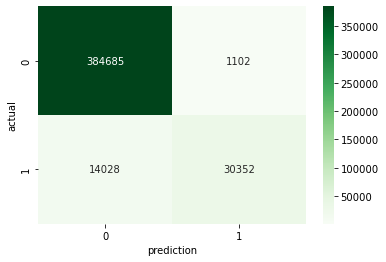

In [32]:
cm_xg = confusion_matrix(y_test, xg_pred)
sns.heatmap(cm_xg, annot=True, cmap='Greens', fmt='.10g')
plt.xlabel('prediction')
plt.ylabel('actual')

In [36]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [33]:
xg_pred_prob = xgbC.predict_proba(X_testS)

In [38]:
xg_pred_prob = xg_pred_prob[:,1]

In [39]:
thresholds = [0.2, 0.4, 0.6, 0.8]

In [44]:
scores = [f1_score(y_test, to_labels(xg_pred_prob, t)) for t in thresholds]
ix = np.argmax(scores)
print('Threshold=%.3f, Recall_Score=%.5f' % (thresholds[ix], scores[ix]))

In [45]:
ix = np.argmax(scores)
print('Threshold=%.3f, Recall_Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.400, Recall_Score=0.85330


In [52]:
print(classification_report(y_test, to_labels(xg_pred_prob, 0.3)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99    385787
           1       0.86      0.88      0.87     44380

    accuracy                           0.97    430167
   macro avg       0.92      0.93      0.93    430167
weighted avg       0.97      0.97      0.97    430167



Text(33.0, 0.5, 'actual')

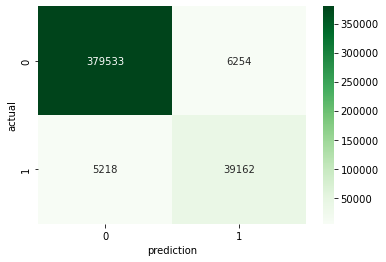

In [53]:
cm_xg = confusion_matrix(y_test, to_labels(xg_pred_prob, 0.3))
sns.heatmap(cm_xg, annot=True, cmap='Greens', fmt='.10g')
plt.xlabel('prediction')
plt.ylabel('actual')

* including text data - only 100 features increased recall to 0.68 (for prediction 1)
* 0.7 improvement than without the text 

In [110]:
search_best = search.best_estimator_

In [111]:
search_pred = search_best.predict_proba(X_test)

In [112]:
search_pred_prob = search_pred[:,1]

In [117]:
print(classification_report(y_test, to_labels(search_pred_prob, 0.3)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    385787
           1       0.93      0.72      0.81     44380

    accuracy                           0.97    430167
   macro avg       0.95      0.86      0.90    430167
weighted avg       0.96      0.97      0.96    430167



In [121]:
best_pred = best_search.predict_proba(X_test)

In [122]:
best_pred_prob = best_pred[:,1]

In [209]:
print(classification_report(y_test, to_labels(best_pred_prob, 0.3)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    385787
           1       0.99      0.95      0.97     44380

    accuracy                           0.99    430167
   macro avg       0.99      0.98      0.98    430167
weighted avg       0.99      0.99      0.99    430167



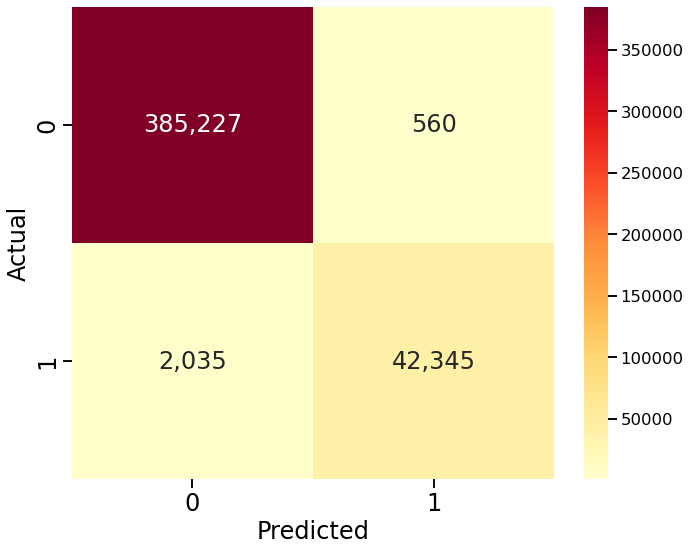

In [224]:
cm_best = confusion_matrix(y_test, to_labels(best_pred_prob, 0.3))
with sns.plotting_context('talk'):
    plt.figure(figsize=(10,8))
    sns.heatmap(cm_best, annot=True, cmap='YlOrRd', fmt=',', annot_kws={"fontsize":24})
    plt.xlabel('Predicted', fontsize=24)
    plt.ylabel('Actual', fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.savefig('conf_matrix.png', dpi=300)
    plt.tight_layout()

In [137]:
best_scores = [f1_score(y_test, to_labels(best_pred_prob, t)) for t in thresholds]
ix = np.argmax(best_scores)
print('Threshold=%.3f, F1_score=%.5f' % (thresholds[ix], best_scores[ix]))

Threshold=0.200, F1_score=0.97278
